---
layout: page
title: Padronização e a Distribuição Normal
nav_order: 17
---
[<img src="https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/colab_favicon_small.png" style="float: right;">](https://colab.research.google.com/github/flaviovdf/fcd/blob/master/_lessons/17-Normalidade.ipynb)

# Tópico 17 – Padronização e a Distribuição Normal
{: .no_toc .mb-2 }

Depois de aprendermos sobre as medidas que podemos utilizar para caracterizar a centralidade e a dispersão de uma distribuição (e a relação dessas medidas com algumas probabilidades de interesse), veremos uma distribuição muito importante em Ciência de Dados e que pode ser completamente caracterizada por sua média e variância: a distribuição Normal. Discutiremos como essa distribuição surge naturalmente em diversos fenômenos da natureza, e como suas propriedades podem nos ajudar a realizar inferência para uma população. Vamos introduzir e explorar também o conceito de padronização, e a importância de se padronizar certos conjuntos de variáveis para uma análise mais coerente.
{: .fs-6 .fw-300 }

{: .no_toc .text-delta }
Resultados Esperados

1. Introduzir o conceito de padronização e aprender a interpretar as medidas correspondentes.
1. Introduzir a distribuição Normal, motivar suas propriedades e ilustrar sua utilização na prática.
1. Comparar os resultados da Desigualdade de Chebyshev em um contexto sobre o qual temos mais informação sobre a distribuição de interesse.

{: .no_toc .text-delta }
Material Adaptado do [DSC10 (UCSD)](https://dsc10.com/)

In [1]:
import numpy as np
import babypandas as bpd
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

# Animations
import ipywidgets as widgets
from IPython.display import display, HTML

def normal_curve(x, mu=0, sigma=1):
    return (1 / np.sqrt(2 * np.pi * sigma ** 2)) * np.exp((- (x - mu) ** 2) / (2 * sigma ** 2))

def show_many_normal_distributions():
    plt.figure(figsize=(10, 5))
    x = np.linspace(-40, 40, 10000)
    pairs = [(0, 1, 'black'), (10, 1, 'blue'), (-15, 4, 'red'), (20, 0.5, 'green')]

    for pair in pairs:
        y = normal_curve(x, mu=pair[0], sigma=pair[1])
        plt.plot(x, y, color=pair[2], linewidth=3, label=f'Normal(mean={pair[0]}, SD={pair[1]})')

    plt.xlim(-40, 40)
    plt.ylim(0, 1)
    plt.title('Normal Distributions with Different Means and Standard Deviations')
    plt.legend();

def normal_area(a, b, bars=False):
    x = np.linspace(-4, 4, 1000)
    y = normal_curve(x)
    ix = (x >= a) & (x <= b)
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, color='black')
    plt.fill_between(x[ix], y[ix], color='gold')
    if bars:
        plt.axvline(a, color='red')
        plt.axvline(b, color='red')
    plt.title(f'Area between {np.round(a, 2)} and {np.round(b, 2)}')
    plt.show()

def sliders():
    a = widgets.FloatSlider(value=0, min=-4,max=3,step=0.25, description='a')
    b = widgets.FloatSlider(value=1, min=-4,max=4,step=0.25, description='b')
    bars = widgets.Checkbox(value=False, description='bars')
    ui = widgets.HBox([a, b, bars])
    out = widgets.interactive_output(normal_area, {'a': a, 'b': b, 'bars': bars})
    display(ui, out)

## Recapitulando: Desigualdade de Chebyshev

### Variância e desvio padrão

- A variância é igual à média dos desvios quadrados em torno da média.
    - O desvio padrão é igual a raiz quadrada da variância.

Formalmente,

$$\begin{align*}
    S^2 &:= \frac{\sum^n_{i=1} (X_i - \bar{X})^2}{n}, & S &= \sqrt{S^2} = \sqrt{\frac{\sum^n_{i=1} (X_i - \bar{X})^2}{n}}.
\end{align*}$$

### Desigualdade de Chebyshev

A desigualdade de Chebyshev nos diz que, para uma certa distribuição de probabilidade, a probabilidade dos valores estarem a a $k$ DPs da média é de, no mínimo

$$1 - \frac{1}{k^2}.
$$

## Padronização

### Exemplo: Alturas e pesos  📏

Para exemplificar, comecemos com um conjunto de dados com as alturas e pesos de $n = 5,000$ homens adultos.

In [2]:
height_and_weight = bpd.read_csv('https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/17-Normalidade/data/height_and_weight.csv')
height_and_weight

,Height,Weight
0,73.85,241.89
1,68.78,162.31
2,74.11,212.74
...,...,...
4997,67.01,199.20
4998,71.56,185.91
4999,70.35,198.90


### Distribuições das alturas e pesos

Vamos analisar a distribuição das variáveis do nosso conjunto.

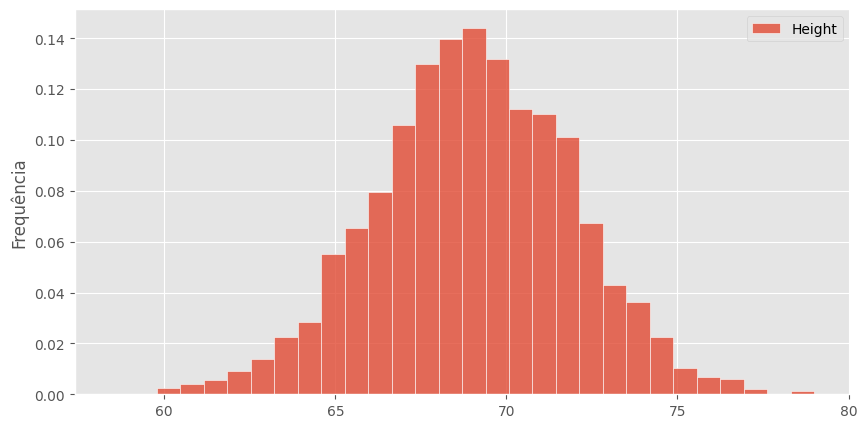

In [3]:
height_and_weight.plot(kind='hist', y='Height', density=True, ec='w', bins=30, alpha=0.8, figsize=(10, 5))
plt.ylabel("Frequência");

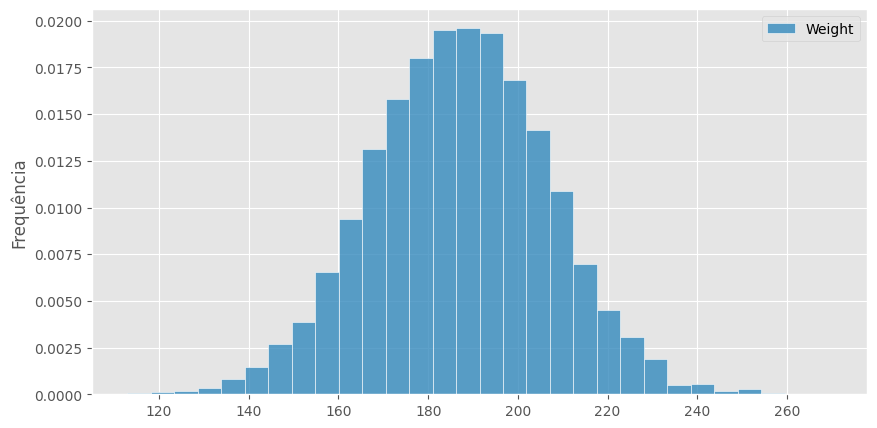

In [4]:
height_and_weight.plot(kind='hist', y='Weight', density=True, ec='w', bins=30, alpha=0.8, color='C1', figsize=(10, 5))
plt.ylabel("Frequência");

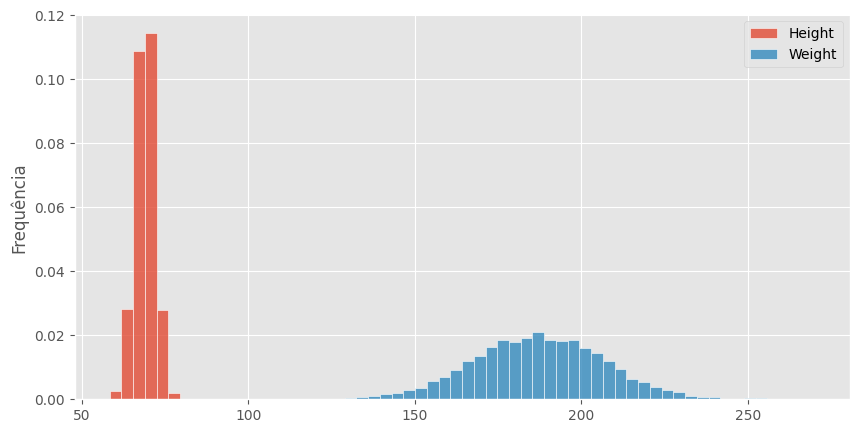

In [5]:
height_and_weight.plot(kind='hist', density=True, ec='w', bins=60, alpha=0.8, figsize=(10, 5))
plt.ylabel("Frequência");

**Observação**: As duas distribuições acima são similares à versões "deslocadas" e "esticadas" da mesma forma, denominada informalmente de **"curva de sino"** (_bell curve_) 🔔.

Veremos mais formalmente que uma distribuição com essa forma é conhecida como **distribuição Normal**.

### Diferentes "normais"

- A Normal é, mais corretamente, uma **família** de distribuições.

- Existem várias distribuições normais. Todas têm "forma de sino", mas variam em locação ("centralidade") e dispersão ("largura").
    - A locação e a dispersão na Normal são fundamentalmente expressos por sua média e variância, respectivamente.

- A média e a variância definem _unicamente_ uma distribuição Normal.
    - Isto é, para uma dada média e variância, existe apenas _uma_ distribuição Normal correspondente.

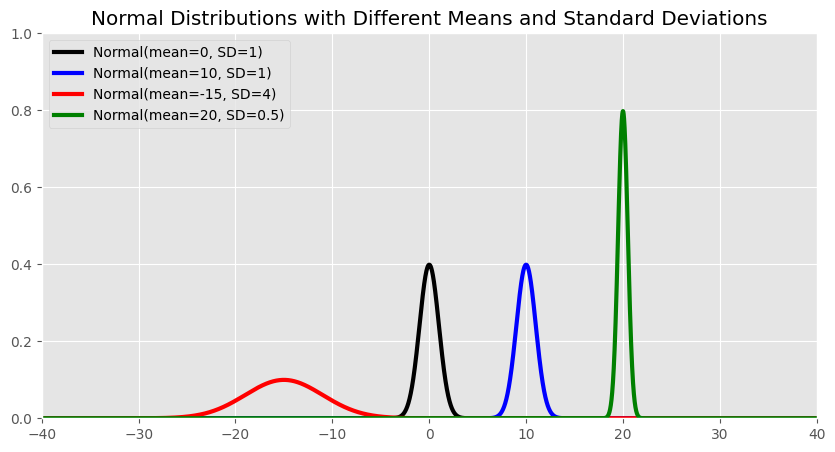

In [6]:
show_many_normal_distributions()

- **Nota**: como cada curva acima representa uma distribuição de probabilidade, a área abaixo de cada curva é sempre igual a 1.
    - Dessa maneira, as curvas mais "altas" serão mais "curtas", e as curvas mais "baixas" serão mais "largas".
    - Reforçando esse ponto mais uma vez, a altura de cada curva dependerá necessariamente da variância.
        - Quanto maior a variância, mais larga (e mais baixa) será a Normal correspondente.
        - Quanto menor a variância, mais curta (e mais alta) será a Normal correspondente.

- A distribuição Normal _sempre_ pode ser **deslocada** e **reescalada** de maneira a ficar _igual_ a qualquer outra distribuição Normal.
    - Mais formalmente, dizemos que a distribuição Normal é _invariante a transformações lineares_.
    - Equivalentemente, podemos dizer também que a _normalidade é mantida/preservada sob transformações lineares_.

Vamos ilustrar como a padronização funciona na prática abaixo com alturas e pesos.

### Unidades padronizadas

Suponha que $X$ seja uma variável aleatória (numérica) com média $\mu$ e desvio padrão $\sigma$, e que $X_i$ seja um valor (realização) dessa variável. Então,

\begin{align*}
    Z_i := \frac{X_i - \mu}{\sigma}
\end{align*}

representa $X_i$ em **unidades padronizadas**, isto é, o _número de DPs que $X_i$ está de sua média_.

Equivalentemente, se $Z_i = z \in \mathbb{R}$, então podemos dizer que $X_i$ está a $z$ DPs da média.

> Lembre da Desigualdade de Chebyshev acima!

**Exemplo**: Suponha que uma pessoa pese 225 libras. Qual é o seu peso em unidades padronizadas?

In [7]:
weights = height_and_weight.get('Weight')
(225 - weights.mean()) / np.std(weights)

1.9201699181580782

- Interpretação: 225 está a 1.92 desvios-padrão acima da média dos pesos.
- 225 libras é igual a 1.92 em unidades padronizadas.

**Nota**: a padronização sempre depende do valor de $\mu$ e $\sigma$, que são _específicos_ à cada distribuição. 

### Padronização

O processo de conversão dos valores de uma variável para unidades padronizadas é conhecido como **padronização**. 

Consequentemente, os valores $Z_i$ obtidos através da padronização são ditos **padronizados**.

In [8]:
def standard_units(col):
    return (col - col.mean()) / np.std(col)

In [9]:
standardized_height = standard_units(height_and_weight.get('Height'))
standardized_height

0       1.68
1      -0.09
2       1.78
        ... 
4997   -0.70
4998    0.88
4999    0.46
Name: Height, Length: 5000, dtype: float64

In [10]:
standardized_weight = standard_units(height_and_weight.get('Weight'))
standardized_weight

0       2.77
1      -1.25
2       1.30
        ... 
4997    0.62
4998   -0.06
4999    0.60
Name: Weight, Length: 5000, dtype: float64

### O efeito da padronização

Variáveis padronizadas sempre têm:
- Média igual a 0.
- Variância = desvio padrão = 1.

É comum padronizarmos diferentes variáveis simplesmente para termos todas na mesma escala.

In [11]:
# e-15 means 10^(-15), which is a very small number, effectively zero.
standardized_height.describe()

count    5.00e+03
mean     1.49e-15
std      1.00e+00
           ...   
50%      4.76e-04
75%      6.85e-01
max      3.48e+00
Name: Height, Length: 8, dtype: float64

In [12]:
standardized_weight.describe()

count    5.00e+03
mean     5.98e-16
std      1.00e+00
           ...   
50%      6.53e-04
75%      6.74e-01
max      4.19e+00
Name: Weight, Length: 8, dtype: float64

Veja abaixo como o processo de padronização funciona nesse exemplo.

In [13]:
HTML('https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/17-Normalidade/data/height_anim.html')

In [14]:
HTML('https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/17-Normalidade/data/weight_anim.html')

### Histogramas padronizados

Agora que padronizamos as distribuições dos pesos e das alturas, vamos ver mais uma vez como seus histogramas ficam lado-a-lado.

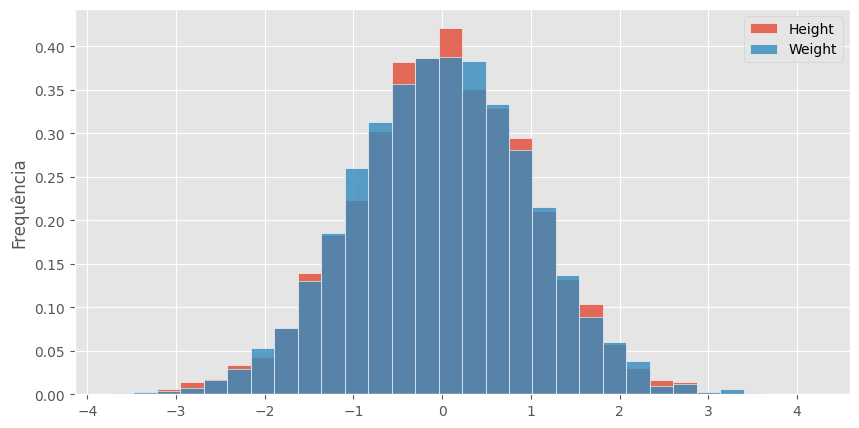

In [15]:
standardized_height_and_weight = bpd.DataFrame().assign(
    Height=standardized_height,
    Weight=standardized_weight
)
standardized_height_and_weight.plot(kind='hist', density=True, ec='w',bins=30, alpha=0.8, figsize=(10, 5))
plt.ylabel("Frequência");

Ambos ficaram bem parecidos!

## A distribuição Normal padrão

### Padronizando a distribuição Normal

- As distribuições vistas anteriormente são muito parecidas após a padronização.
- Uma distribuição Normal padronizada é denominada de **distribuição Normal padrão**.
    - A distribuição Normal padrão é caracterizada unicamente por sua média 0 e variância igual a 1.

- Formalmente, a função que define a **curva Normal padrão**, isto é, que descreve a distribuição de uma variável aleatória Normal padronizada, é denotada por

\begin{equation*}
\phi(z) := \frac{1}{\sqrt{2 \pi}} e^{-\frac{1}{2}z^2}, \,\, z \in \mathbb{R}.
\end{equation*}

### A curva Normal padrão

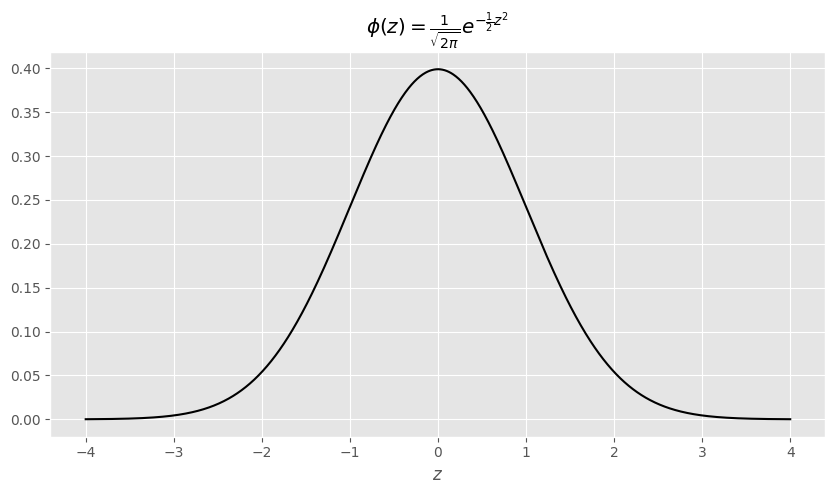

In [16]:
def normal_curve(z):
    return 1 / np.sqrt(2 * np.pi) * np.exp((-z**2)/2)

x = np.linspace(-4, 4, 1000)
y = normal_curve(x)

plt.figure(figsize=(10, 5))
plt.plot(x, y, color='black');
plt.xlabel('$z$');
plt.title(r'$\phi(z) = \frac{1}{\sqrt{2 \pi}} e^{-\frac{1}{2}z^2}$');

### Alturas e pesos são "aproximadamente normais"

Dizemos que, se uma distribuição tem uma curva "similar" à curva Normal, que essa distribuição é "aproximadamente Normal".

De maneira equivalente, podemos dizer que a população/amostra (ou a variável aleatória em questão) é aproximadamente normalmente distribuída.

> Se $X$ é normalmente distribuída com média $\mu$ e variância $\sigma^2$, _sempre é possível_ padronizar $X$ através de $$Z := \frac{X - \mu}{\sigma},$$
> onde nesse caso $Z$ tem distribuição Normal padrão.

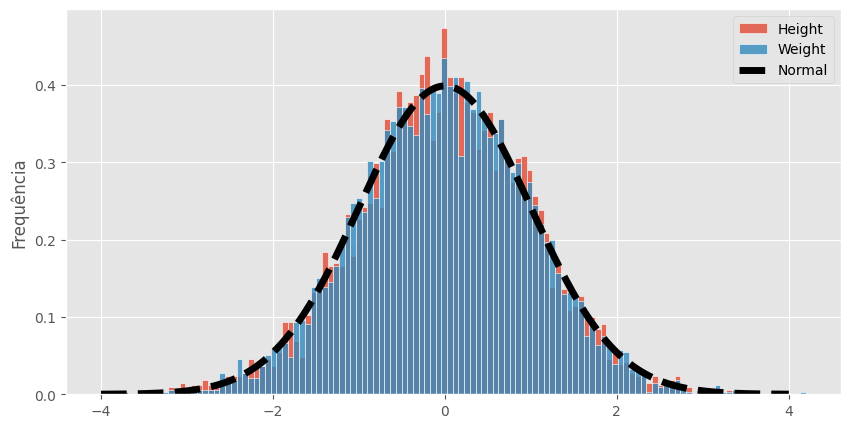

In [17]:
standardized_height_and_weight.plot(kind='hist', density=True, ec='w', bins=120, alpha=0.8, figsize=(10, 5));
plt.plot(x, y, color='black', linestyle='--', label='Normal', linewidth=5)
plt.legend(loc='upper right')
plt.ylabel("Frequência");

### A distribuição Normal padrão

- Podemos pensar na curva de uma distribuição _contínua_ (como a Normal) como um "análogo contínuo" do histograma.

- A distribuição Normal padrão tem mediana e moda ambas iguais à zero.
    - Isso implica que a Normal padrão é _simétrica_ (em torno de 0).
    - A _moda_ da Normal também é sempre igual à média e a mediana (e logo igual a 0 no caso padrão). 

- A curva da distribuição Normal padrão tem _pontos de inflexão_ em $\pm 1$.
    - Veremos mais sobre isso adiante.

- Similar ao que temos para um histograma, na curva de qualquer distribuição contínua:
    - A **área** do intervalo $[a, b]$ representa a **probabilidade** dos valores entre $a$ e $b$.
    - A área total abaixo da curva é igual a 1.

In [18]:
sliders()

Output()

### Função de distribuição acumulada

- A **função de distribuição acumulada** (CDF, do inglês _cumulative density function_) de uma variável aleatória é uma função $F(x)$ que toma valores $x \in \mathbb{R}$ e retorna a probabilidade dos valores que são _menores ou iguais à $x$_, isto é, a _área sob a curva à esquerda de x$_.

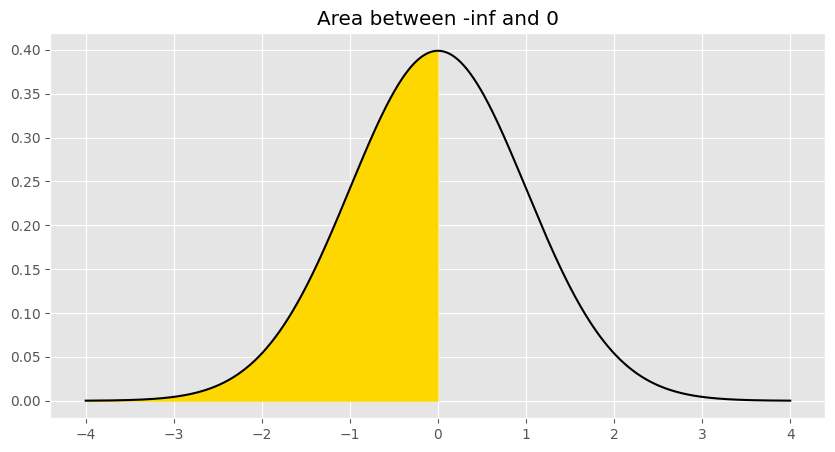

In [19]:
# cdf(0) should give us the gold area below.
normal_area(-np.inf, 0)

- Para encontrar áreas sob curvas, em geral utilizamos integração (i.e. cálculo integral).
    - Porém, infelizmente a curva Normal padrão não tem uma integral _analítica_, isto é, com forma fechada!

- Uma alternativa comum é a utilização de [tabelas](https://www.math.arizona.edu/~jwatkins/normal-table.pdf) que contém aproximações da CDF da Normal padrão.
    - Em essência, as tabelas são construídas a partir de aproximações numéricas.

- Aqui, construíremos nossas próprias aproximações numéricas!
    - Mais especificamente, utilizaremos a função `scipy.stats.norm.cdf(z)` para calcular a **área da curva Normal padrão à esquerda de `z`**.

### Áreas sob a curva Normal padrão

Qual você acha que é o valor de `scipy.stats.norm.cdf(0)`? Por quê?

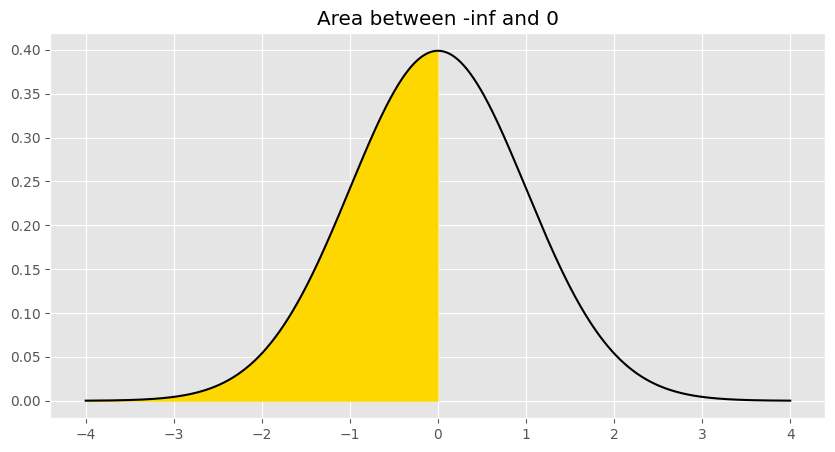

In [20]:
normal_area(-np.inf, 0)

In [21]:
from scipy import stats
stats.norm.cdf(0)

0.5

Suponha agora que estejamos interessados na área **à direita** de $z = 2$ sob a curva Normal padrão.

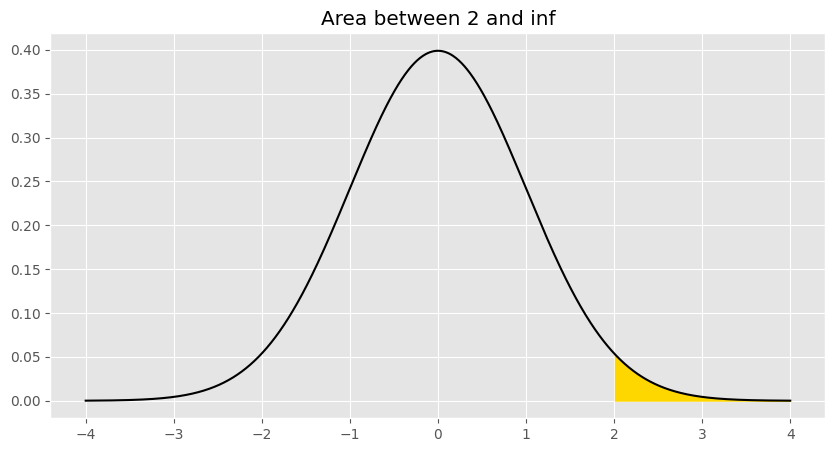

In [22]:
normal_area(2, np.inf)

A expressão abaixo nos dá a área **à esquerda** de $z = 2$.

In [23]:
stats.norm.cdf(2)

0.9772498680518208

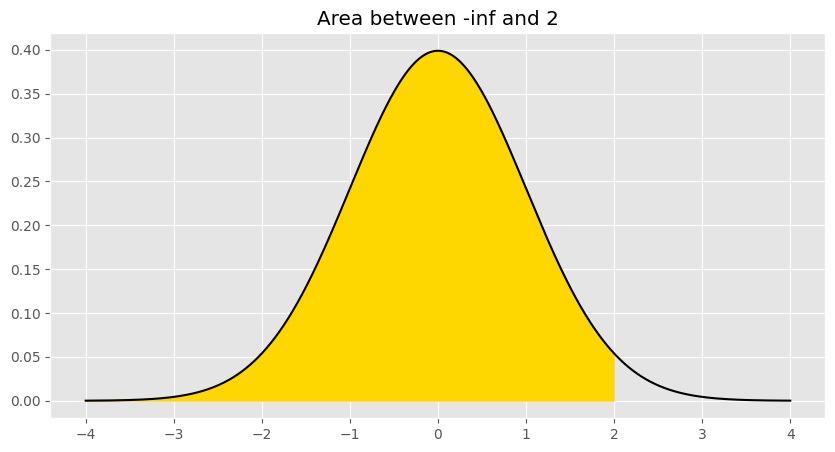

In [24]:
normal_area(-np.inf, 2)

Porém, como a área _total_ sob a curva Normal padrão é sempre igual a 1, temos, para todo $z \in \mathbb{R}$, que a área **á direita** de $z$ é dada por

\begin{equation*}
    1 - F(z).
\end{equation*}

Em particular, tomando $z = 2$, temos

In [25]:
1 - stats.norm.cdf(2)

0.02275013194817921

Agora, como podemos utilizar a função `stats.norm.cdf` para calcular a área entre $a = -1$ e $b = 0$?

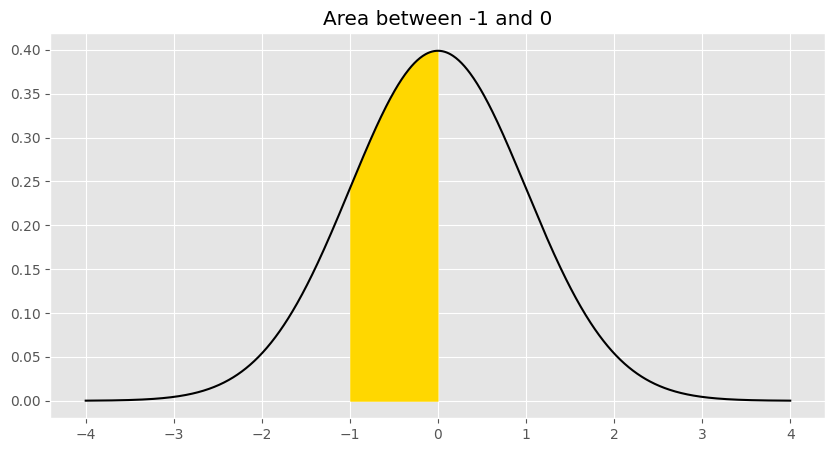

In [26]:
normal_area(-1, 0)

Nossa estratégia aqui será calcular a área entre $a = -1$ e $b = 0$ como

- a área **à esquerda** de $b = 0$
- subtraída da área **à esquerda** de $a = -1$.

In [27]:
stats.norm.cdf(0) - stats.norm.cdf(-1)

0.3413447460685429

Em geral, a área sobre uma curva contínua no intervalo $[a, b]$ é sempre igual a $F(b) - F(a)$.

No Python, esse cálculo pode ser feito como

```py
stats.norm.cdf(b) - stats.norm.cdf(a)
```

Outra propriedade importante da distribuição Normal que podemos utilizar para calcular probabilidades de interesse é a _reflexividade em torno da média_.

- Para a Normal padrão, essa propriedade diz que $F(z) = F(-z)$, facilitando o cálculo de áreas sob a curva **á direita de $z$.

In [28]:
## compare with the previous result, i.e. 1 - stats.norm.cdf(2)
stats.norm.cdf(-2)

0.022750131948179195

Ainda outras 2 propriedades (que vale para quaisquer distribuições contínuas) importantes das CDFs são

\begin{align*}
    F(-\infty) :&= \lim_{x \rightarrow -\infty} F(x) = 0,  &  F(+\infty) :&= \lim_{x \rightarrow +\infty} F(x) = 1,
\end{align*}

o que implica que 
- a área entre $a \rightarrow - \infty$ e $b = x$ (isto é, a área _à esquerda_ de $a$) é igual a $F(x) - F(-\infty) = F(x)$
- e que a área entre $a = x$ e $b \rightarrow +\infty$ (isto é, a área _à direita_ de $a$) é igual a $F(+\infty) - F(x) = 1 - F(x)$.

### Utilizando a distribuição Normal

Vamos voltar ao nosso exemplo de alturas e pesos.

In [29]:
height_and_weight

,Height,Weight
0,73.85,241.89
1,68.78,162.31
2,74.11,212.74
...,...,...
4997,67.01,199.20
4998,71.56,185.91
4999,70.35,198.90


Recapitulando o que estabelecemos anteriormente, essas duas variáveis são aproximadamente normais.

Como podemos então utilizar essa informação?

### Unidades padronizadas e a distribuição Normal padrão

- **Ideia principal: o eixo $x$ em uma curva Normal <u>padrão</u> é expresso em unidades <u>padronizadas</u>.**
    - Por exemplo, a área entre -1 e 1 é a proporção de valores a 1 DP da média.

- Suponha que uma distribuição seja (aproximadamente) Normal.
- Nesse caso ambas quantidades são aproximadamente iguais:
    - A proporção de valores na distribuição entre $a$ e $b$.
    - A área entre $\frac{a - \bar{X}}{S}$ e $\frac{b - \bar{X}}{S}$ sob a curva Normal padrão.

### Exemplo: Proporção de pesos entre 200 e 225 libras

Suponhamos que não tenhamos acesso à população inteira dos pesos, mas apenas à sua média e DP.

In [30]:
weight_mean = weights.mean()
weight_mean

187.0206206581932

In [31]:
weight_std = np.std(weights)
weight_std

19.779176302396458

Utilizando essa informação, podemos aproximar a proporção dos pesos entre 200 e 225 libras através da distribuição Normal padrão da seguinte forma: 

1. Convertemos 200 para unidades padronizadas.
1. Convertemos 225 para unidades padronizadas.
1. Utilizamos a diferença entre `stats.norm.cdf` nas unidades padronizadas para encontrar a área entre elas.

In [32]:
left = (200 - weight_mean) / weight_std
left

0.656214351061435

In [33]:
right = (225 - weight_mean) / weight_std
right

1.9201699181580782

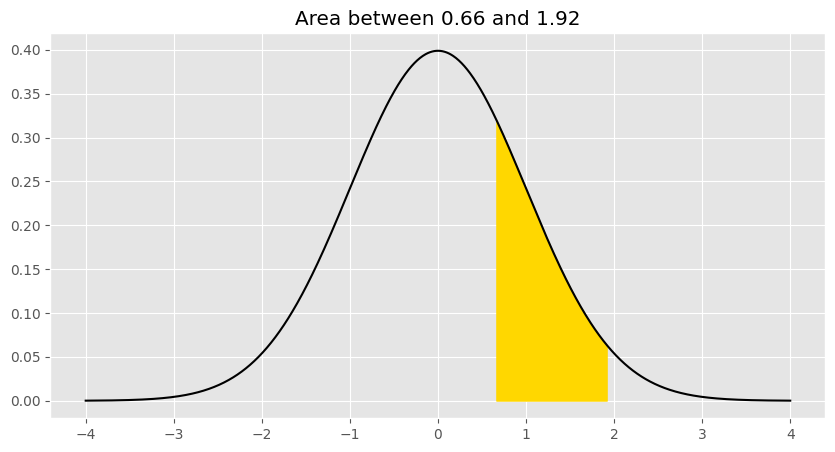

In [34]:
normal_area(left, right)

In [35]:
approximation = stats.norm.cdf(right) - stats.norm.cdf(left)
approximation

0.22842488819306406

### Verificando a qualidade da aproximação

Como temos acesso à população de pesos, podemos calcular a proporção verdadeira dos pesos entre 200 e 225 libras.

In [36]:
# True proportion of values between 200 and 225.
height_and_weight[
    (height_and_weight.get('Weight') >= 200) &
    (height_and_weight.get('Weight') <= 225)
].shape[0] / height_and_weight.shape[0]

0.2294

In [37]:
# Approximation using the standard normal curve.
approximation

0.22842488819306406

Boa aproximação! 🤩

### Cuidado: A padronização não faz com que uma distribuição seja Normal!

Considere mais uma vez a distribuição dos atrasos de vôos das aulas passadas.

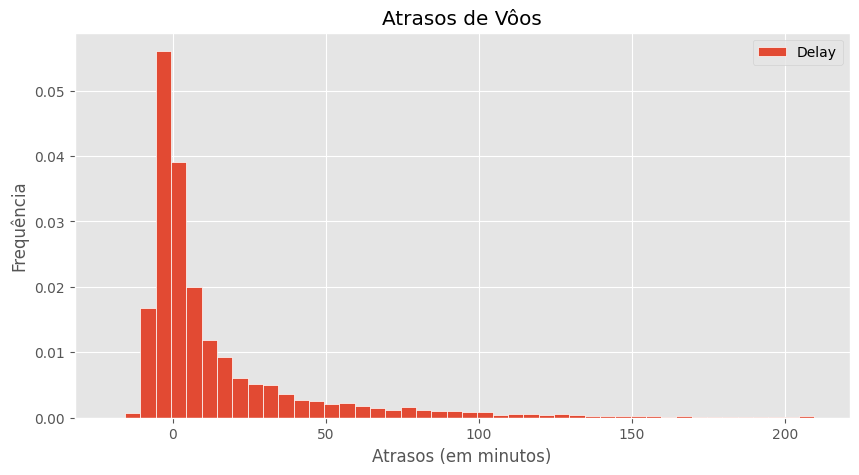

In [38]:
delays = bpd.read_csv('https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/17-Normalidade/data/united_summer2015.csv')
delays.plot(kind='hist', y='Delay', bins=np.arange(-20.5, 210, 5), density=True, ec='w', figsize=(10, 5))
plt.title('Atrasos de Vôos')
plt.xlabel('Atrasos (em minutos)')
plt.ylabel("Frequência");

A distribuição acima não parece ser aproximadamente Normal, e isso **não muda com a padronização**.

> Ao padronizar uma distribuição, modificamos apenas sua _locação_ e _dispersão_: a **forma** da distribuição não se altera.

In [39]:
HTML('https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/17-Normalidade/data/delay_anim.html')

### A Desigualdade de Chebyshev e a distribuição Normal

- Lembre que a Desigualdade de Chebyshev nos diz que a proporção dos valores a $k$ DPs da média é **no mínimo** igual a $1 - \frac{1}{k^2}$.
    - Isso vale para **qualquer** distribuição, mas lembre que essa é uma cota _inferior_.

- Se soubermos que uma distribuição é Normal, podemos ser ainda mais precisos!

| $k$ | Intervalo | Probabilidade <br> (via Chebyshev) | Probabilidade <br> (na Normal) |
| ----- | ----- | ----- | ----- |
|$k = 1$ | $\bar{X} \pm 1 \cdot \sigma$ | $\geq 1 - \frac{1}{1} =  0\%$ | $\simeq 68\%$ |
|$k = 2$ | $\bar{X} \pm 2 \cdot \sigma$ | $\geq 1 - \frac{1}{4} = 75\%$ | $\simeq 95\%$
|$k = 3$ | $\bar{X} \pm 3 \cdot \sigma$ | $\geq 1 - \frac{1}{9} \simeq 88.88\%$ | $\simeq 99.73\%$ |

### Na Normal, 68% dos valores estão a 1 DP da média

Lembre que os valores no eixo $x$ da curva Normal padrão estão em unidades padronizadas.

> Logo, a proporção dos valores a 1 DP da média sob a curva Normal padrão estarão entre -1 e 1.

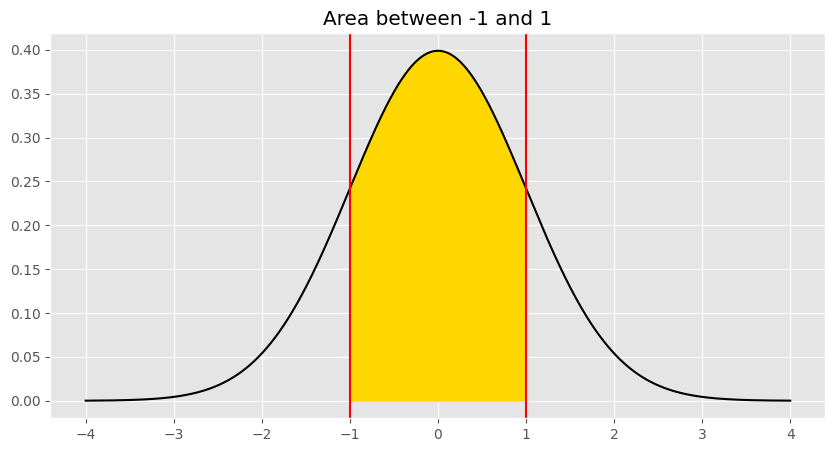

In [40]:
normal_area(-1, 1, bars=True)

In [41]:
stats.norm.cdf(1) - stats.norm.cdf(-1)

0.6826894921370859

Isso implica que, se uma variável têm distribuição Normal, aproximadamente 68% dos valores estarão a 1 DP da média.

### Na Normal, 95% dos valores estão a 2 DPs da média

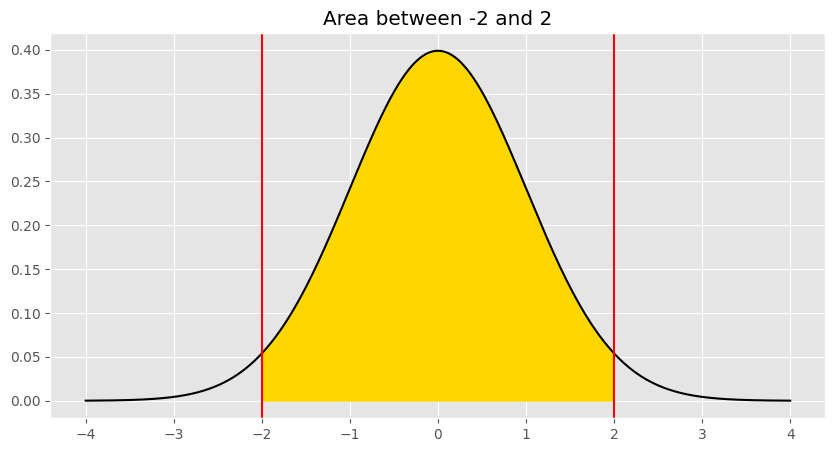

In [42]:
normal_area(-2, 2, bars=True)

In [43]:
stats.norm.cdf(2) - stats.norm.cdf(-2)

0.9544997361036416

- Na distribuição Normal, aproximadamente 95% dos valores estarão a 2 DPs da média.
- Consequentemente, 5% dos valores estarão fora desse intervalo.
- Além disso, como a Normal é simétrica: 
    - 2.5% dos valores estarão a mais de 2 DPs da média
    - e 2.5% dos valores estarão a menos de 2 DPs da média.

### Recapitulando (mais uma vez): Proporção dos valores a $k$ DPs da média

| $k$ | Intervalo | Probabilidade <br> (via Chebyshev) | Probabilidade <br> (na Normal) |
| ----- | ----- | ----- | ----- |
|$k = 1$ | $\bar{X} \pm 1 \cdot \sigma$ | $\geq 1 - \frac{1}{1} =  0\%$ | $\simeq 68\%$ |
|$k = 2$ | $\bar{X} \pm 2 \cdot \sigma$ | $\geq 1 - \frac{1}{4} = 75\%$ | $\simeq 95\%$
|$k = 3$ | $\bar{X} \pm 3 \cdot \sigma$ | $\geq 1 - \frac{1}{9} \simeq 88.88\%$ | $\simeq 99.73\%$ |

As probabilidades reportadas acima para a distribuição Normal são **aproximadas**, _mas não são cotas inferiores_.

**Importante**: Essas probabilidades na verdade valem para **todas** as distribuições normais, padronizadas ou não.

> Isso se deve ao fato de que a distribuição Normal padrão pode ser obtidad a partir de _qualquer distribuição Normal_ através de uma padronização adequada (e vice-versa).
> 
> > Algebricamente, se $X$ tem distribuição Normal com média $\mu$ e DP $\sigma$ e $Z = \frac{X - \mu}{\sigma}$ tem distribuição Normal padrão, então $X = \mu + \sigma Z$.

### Pontos de inflexão

- Mencionamos anteriormente que a curva Normal padrão possui pontos de inflexão em $z = \pm 1$.
    - Informalmente, um ponto de inflexão é um onde a curva passa de "curvada para baixo" 🙁 para "curvada para cima" 🙂.

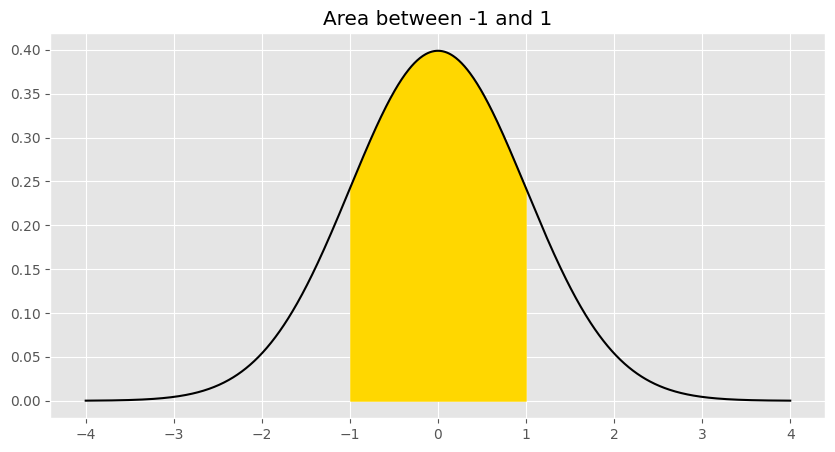

In [44]:
normal_area(-1, 1)

- Como o eixo $x$ da curva Normal padrão está expresso em unidades padronizadas, então para qualquer distribuição Normal os pontos de inflexão estarão a 1 DP abaixo e acima da média $\mu$.

- Isso implica que, se uma distribuição é aproximadamente Normal, então podemos encontrar seu desvio padrão apenas medindo a distância entre cada ponto de inflexão dessa distribuição e sua média.

### Exemplo: distribuição das alturas

Lembre que a distribuição das alturas é aproximadamente Normal, mas _não uma Normal padrão_.

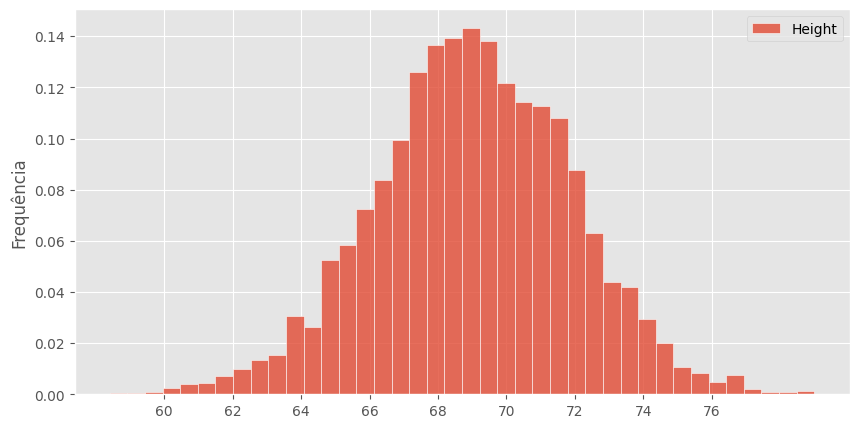

In [45]:
height_and_weight.plot(kind='hist', y='Height', density=True, ec='w', bins=40, alpha=0.8, figsize=(10, 5));
plt.xticks(np.arange(60, 78, 2))
plt.ylabel("Frequência");

- A média/mediana parece estar em torno de 69.
- Os pontos de inflexão parecem estar em torno de 66 e 72.
- Dessa forma, o desvio padrão é aproximadamente 72 - 69 = 3, ou 69 - 66 = 3.

In [46]:
np.std(height_and_weight.get('Height'))

2.863075878119538

## Resumo e próxima aula

### Resumo: Unidades padronizadas e a distribuição Normal

- Para converter um valor $X_i$ para unidades padronizadas, fazemos $Z_i := \frac{X_i - \mu}{\sigma}$.
    - Valores em unidades padronizadas medem o número de desvios padrão que $X_i$ está acima (ou abaixo) de sua média.
- A distribuição Normal, cuja curva possui formato de sino, aparece em muitos fenômenos da natureza.
- O eixo $x$ da curva Normal **padrão** é sempre expresso em unidades **padronizadas**.
- Se uma distribuição é aproximadamente Normal, podemos aproximar probabilidades entre intervalos arbitrários de interesse com base nas propriedades da distribuição Normal, bastando apenas saber a média e a variância dessa distribuição.
    - Se uma variável é aproximadamente Normal, então aproximadamente 68% dos seus valores estarão a 1 DP da média, e aproximadamente 95% dos valores estarão a 2 DPs da média.

### Próxima aula

- O Teorema Central do Limite!
- Outra maneira de calcularmos intervalos de confiança.